# From Private Key to Bitcoin Address

We know what is a private key (A random number) and what a public key is (A point on a graph).
Now we're going to see what is the connection between these two and a Bitcoin transaction.

### Step one. Generate a strong private key

Don't forget, private key in nothing more than a random 256 bit (32 bytes) long.
It's recommended not to make this number up by yourself, you can use addresses like bitaddress.org to generate a compatible random address for you.

### Step two. From Private key to public key
Public key multiplaing point G (generator point) on graph SECP256k1 by the Private key.

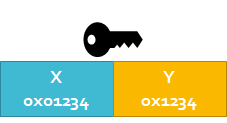

?Is the public key compressed?

In [64]:
import ecdsa

random_number = bytes.fromhex("6C4B84401F6885311FBFEB151DCE1C067316FF693869BAEDBFEF4EE1D16DA115")

signing_key = ecdsa.SigningKey.from_string(random_number, curve = ecdsa.SECP256k1) # Don't forget to specify the curve
verifying_key = signing_key.get_verifying_key()


# The public key is uncompressed and according to the documentation it should be denoted with prefix 0x04
public_key = bytes.fromhex("04") + verifying_key.to_string()

# In order to compress it we need to provide the proper 'sign' of the y cordinate.
# If we plug the X coordinate into the known SECP256K1 we'll get two optional Y cordinate.

x_cor = bytes.fromhex(verifying_key.to_string().hex())[:32] # The first 32 bytes are the x cordinate
y_cor = bytes.fromhex(verifying_key.to_string().hex())[32:] # The last 32 bytes are the y cordinate
if int.from_bytes(y_cor, byteorder="big", signed=True) % 2 == 0: # We need to turn the y_cor into a number. 
    public_key = bytes.fromhex("02" + x_cor.hex())
else:
    public_key = bytes.fromhex("03" + x_cor.hex())
    
print(public_key.hex())

0211c299278e1e1ddefa606b868ac5ad386308a94bccfdeae3d84278a5f230579b


### Step three. Public key to hash public key

Public keys are usually hashed. This is for couple of reasons:
1. Using the ripemd160 hashing algorithm, we can readuce the size of the key to 160 bits (20 bytes).
2. Adding another layer of security. If in the future Eliptic Curve Cryptography will no longer suffice, you coins might still be safe because the hash of your public key cannot be reveresed back to public key.

In [65]:
import hashlib

sha256_1 = hashlib.new("sha256")
sha256_1.update(public_key)

ripemd160 = hashlib.new("ripemd160")
ripemd160.update(sha256_1.digest())

### Step four. Add the network id byte
| Decimal prefix | Hex      | Example use                                    | Leading symbol(s) | Example                                                                                                          |
|----------------|----------|------------------------------------------------|-------------------|------------------------------------------------------------------------------------------------------------------|
| 0              | 00       | Pubkey hash (P2PKH address)                    | 1                 | 17VZNX1SN5NtKa8UQFxwQbFeFc3iqRYhem                                                                               |
| 5              | 05       | Script hash (P2SH address)                     | 3                 | 3EktnHQD7RiAE6uzMj2ZifT9YgRrkSgzQX                                                                               |
| 128            | 80       | Private key (WIF, uncompressed pubkey)         | 5                 | 5Hwgr3u458GLafKBgxtssHSPqJnYoGrSzgQsPwLFhLNYskDPyyA                                                              |
| 128            | 80       | Private key (WIF, compressed pubkey)           | K or L            | L1aW4aubDFB7yfras2S1mN3bqg9nwySY8nkoLmJebSLD5BWv3ENZ                                                             |
| 4 136 178 30   | 0488B21E | BIP32 pubkey                                   | xpub              | xpub661MyMwAqRbcEYS8w7XLSVeEsBXy79zSzH1J8vCdxAZningWLdN3 zgtU6LBpB85b3D2yc8sfvZU521AAwdZafEz7mnzBBsz4wKY5e4cp9LB |
| 4 136 173 228  | 0488ADE4 | BIP32 private key                              | xprv              | xprv9s21ZrQH143K24Mfq5zL5MhWK9hUhhGbd45hLXo2Pq2oqzMMo63o StZzF93Y5wvzdUayhgkkFoicQZcP3y52uPPxFnfoLZB21Teqt1VvEHx |
| 111            | 6F       | Testnet pubkey hash                            | m or n            | mipcBbFg9gMiCh81Kj8tqqdgoZub1ZJRfn                                                                               |
| 196            | C4       | Testnet script hash                            | 2                 | 2MzQwSSnBHWHqSAqtTVQ6v47XtaisrJa1Vc                                                                              |
| 239            | EF       | Testnet Private key (WIF, uncompressed pubkey) | 9                 | 92Pg46rUhgTT7romnV7iGW6W1gbGdeezqdbJCzShkCsYNzyyNcc                                                              |
| 239            | EF       | Testnet Private key (WIF, compressed pubkey)   | c                 | cNJFgo1driFnPcBdBX8BrJrpxchBWXwXCvNH5SoSkdcF6JXXwHMm                                                             |
| 4 53 135 207   | 043587CF | Testnet BIP32 pubkey                           | tpub              | tpubD6NzVbkrYhZ4WLczPJWReQycCJdd6YVWXubbVUFnJ5KgU5MDQrD9 98ZJLNGbhd2pq7ZtDiPYTfJ7iBenLVQpYgSQqPjUsQeJXH8VQ8xA67D |
| 4 53 131 148   | 04358394 | Testnet BIP32 private key                      | tprv              | tprv8ZgxMBicQKsPcsbCVeqqF1KVdH7gwDJbxbzpCxDUsoXHdb6SnTPY xdwSAKDC6KKJzv7khnNWRAJQsRA8BBQyiSfYnRt6zuu4vZQGKjeW4YF |

In [66]:
hashed_public_key = bytes.fromhex("6f") + ripemd160.digest()

### Step five. Create the checksum

The check sum is used to make sure that the address is indeed complete, The fact that the check sum contains the network id bytes is also important to prevent sending transactions to the wrong network.

In [67]:
sha256_2 = hashlib.new("sha256")
sha256_3 = hashlib.new("sha256")

sha256_2.update(hashed_public_key)
sha256_3.update(sha256_2.digest())

checksum = sha256_3.digest()[:4]

### Step five. Append the hashed public key to the checksum and convert to base 58
Base 58 is just another way to represent bytes. The original idea was to create a relativly short address in a format that is somewhat more human readable. The charectar list was also minimized to eliminate potential confusion (1, l, i, I, 0, o).

| Value | Character | Value | Character | Value | Character | Value | Character |
|-------|-----------|-------|-----------|-------|-----------|-------|-----------|
| 0     | 1         | 1     | 2         | 2     | 3         | 3     | 4         |
| 4     | 5         | 5     | 6         | 6     | 7         | 7     | 8         |
| 8     | 9         | 9     | A         | 10    | B         | 11    | C         |
| 12    | D         | 13    | E         | 14    | F         | 15    | G         |
| 16    | H         | 17    | J         | 18    | K         | 19    | L         |
| 20    | M         | 21    | N         | 22    | P         | 23    | Q         |
| 24    | R         | 25    | S         | 26    | T         | 27    | U         |
| 28    | V         | 29    | W         | 30    | X         | 31    | Y         |
| 32    | Z         | 33    | a         | 34    | b         | 35    | c         |
| 36    | d         | 37    | e         | 38    | f         | 39    | g         |
| 40    | h         | 41    | i         | 42    | j         | 43    | k         |
| 44    | m         | 45    | n         | 46    | o         | 47    | p         |
| 48    | q         | 49    | r         | 50    | s         | 51    | t         |
| 52    | u         | 53    | v         | 54    | w         | 55    | x         |
| 56    | y         | 57    | z         |       |           |       |           |



?Is Bitcoin address case sensitive?

In [68]:
import base58

FINALE_BTC_ADDRESS = base58.b58encode(hashed_public_key + checksum)
print (FINALE_BTC_ADDRESS)

b'mq2PhMj3mLg9LirMEgeyRgcUQmo2kNfoek'


### Exercise:

Generate a testnet address (Change the network byte).
Keep the private key used to generate that address! you'll need it!

Send your testnet address to shlomi.zeltsinger@gmail.com

### Exercise:
Write the P2SH address for the script we did in class: 767695950887.

In [69]:
# Example for script
script = bytes.fromhex("5176937693769376936087")

import hashlib

sha256_1 = hashlib.new("sha256")
sha256_1.update(script)

ripemd160 = hashlib.new("ripemd160")
ripemd160.update(sha256_1.digest())

hashed_public_key = bytes.fromhex("05") + ripemd160.digest()

sha256_2 = hashlib.new("sha256")
sha256_3 = hashlib.new("sha256")

sha256_2.update(hashed_public_key)
sha256_3.update(sha256_2.digest())

checksum = sha256_3.digest()[:4]

import base58

FINALE_BTC_ADDRESS = base58.b58encode(hashed_public_key + checksum)
print (FINALE_BTC_ADDRESS)

b'37HNGJbS3eqE4uHPxy3Fz6SEWh9D1vZmxx'


## Resources

https://en.bitcoin.it/wiki/Address

https://en.bitcoin.it/wiki/Technical_background_of_version_1_Bitcoin_addresses

https://bitcoin-script-debugger.visvirial.com/?input=OP_1%20OP_DUP%20OP_ADD%20OP_DUP%20OP_ADD%20OP_DUP%20OP_ADD%20OP_DUP%20OP_ADD%20OP_16%20OP_EQUAL